In [178]:
import pandas as pd

In [179]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

In [180]:
df.sort_values(['Subject_ID', 'Month'], inplace=True)

# Create the target variable by shifting Hb column backward by 1 month for each patient
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)
df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)


# Define 3-class risk label:
# 0 = Safe (10 ≤ Hb ≤ 12)
# 1 = Risk (Hb < 10)
# 2 = Risk (Hb > 12)
# df['Risk_Label'] = df['Next_Hb'].apply(
#     lambda x: 1 if x < 10 else (2 if x > 12 else 0)
# )
df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)


df = df.dropna(subset=['Next_Hb', 'Risk_Label', 'Hb_diff'])

In [181]:
df

,Subject_ID,Month,Albumin (g/L),BU - post HD,BU - pre HD,Hb (g/dL),S Ca (mmol/L),SCR- post HD (µmol/L),SCR- pre HD (µmol/L),Serum K Post-HD (mmol/L),Serum K Pre-HD (mmol/L),Serum Na Pre-HD (mmol/L),UA (mg/dL),Next_Hb,Hb_diff,Risk_Label
1,RHD_THP_001,2024-02-01,37.7,0.38,14.14,13.1,2.23,97.37,513.60,2.90,4.32,136.0,408.0,12.8,2.1,1
2,RHD_THP_001,2024-03-01,40.6,5.85,12.30,12.8,2.24,276.00,560.00,3.90,4.75,141.4,404.0,12.2,-0.3,1
3,RHD_THP_001,2024-04-01,35.8,6.30,18.90,12.2,1.97,325.40,689.00,4.40,4.20,138.4,487.0,12.9,-0.6,1
4,RHD_THP_001,2024-05-01,36.9,6.75,14.79,12.9,2.53,374.80,601.93,4.90,3.80,138.2,336.0,13.3,0.7,1
5,RHD_THP_001,2024-06-01,34.5,0.48,17.40,13.3,2.14,118.61,610.25,2.50,4.40,140.8,408.0,14.2,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,RHD_THP_045,2024-07-01,31.4,3.54,10.20,8.8,2.30,212.00,398.00,2.80,3.91,135.0,385.0,9.6,-0.5,1
394,RHD_THP_045,2024-08-01,31.4,3.70,8.29,9.6,2.30,162.00,402.50,3.13,3.78,134.6,365.0,10.5,0.8,0
395,RHD_THP_045,2024-09-01,32.6,0.27,11.37,10.5,2.54,63.80,466.00,2.36,4.20,134.0,345.0,11.3,0.9,0
396,RHD_THP_045,2024-10-01,32.6,0.27,8.50,11.3,2.54,63.80,397.00,2.36,4.20,134.0,345.0,11.0,0.8,0


In [182]:
feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb (g/dL)', 'Hb_diff'
]

In [191]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

In [192]:
y_train.value_counts(), y_test.value_counts()

(Risk_Label
 1    109
 0     79
 Name: count, dtype: int64,
 Risk_Label
 1    81
 0    45
 Name: count, dtype: int64)

In [193]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Print class distribution after SMOTE
# print("Class distribution after SMOTE:", Counter(y_train))

[[26 19]
 [25 56]]
              precision    recall  f1-score   support

           0       0.51      0.58      0.54        45
           1       0.75      0.69      0.72        81

    accuracy                           0.65       126
   macro avg       0.63      0.63      0.63       126
weighted avg       0.66      0.65      0.65       126



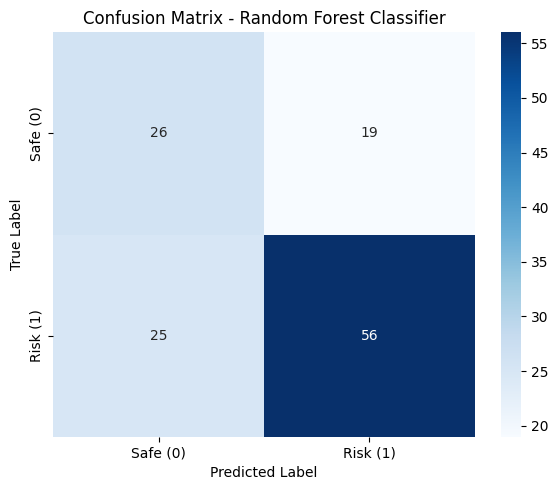

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42, class_weight='balanced', min_samples_split=5,n_estimators=30, max_depth=10, min_samples_leaf=5,  max_features='sqrt')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Risk (1)'],
            yticklabels=['Safe (0)', 'Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.tight_layout()
plt.show()


In [195]:
# Predict
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.91
Test Accuracy: 0.65


In [196]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 20, None],
#     'min_samples_split': [2, 5, 10],
# }

# search = RandomizedSearchCV(
#     RandomForestClassifier(class_weight='balanced', random_state=42),
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=7,
#     scoring='f1_macro',
#     random_state=42,
# )

# search.fit(X_train, y_train)
# best_model = search.best_estimator_

# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Predict on test data
# y_pred = best_model.predict(X_test)

# # Accuracy
# acc = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {acc:.2f}")

# # Classification Report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)

# # Plot Confusion Matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Safe (0)', 'Risk (1)'],
#             yticklabels=['Safe (0)', 'Risk (1)'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()


AUC Score: 0.68


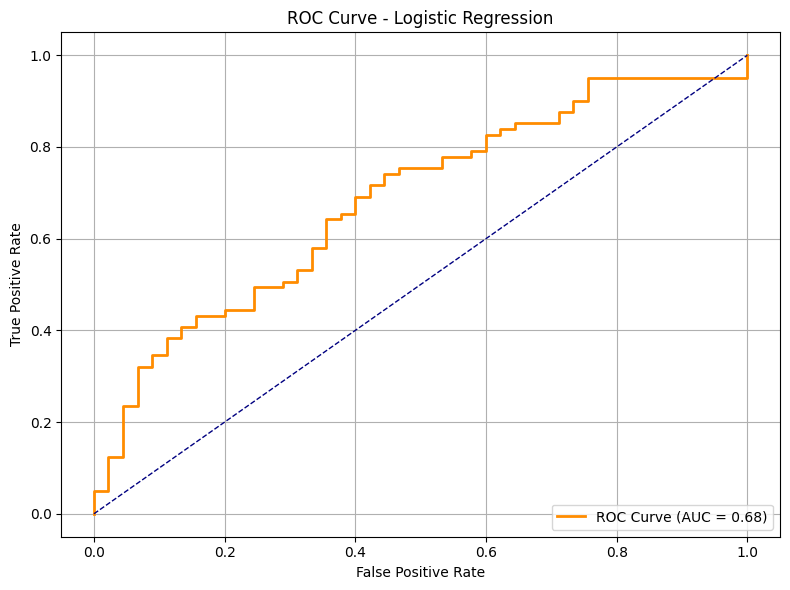

In [197]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

y_test_proba = clf.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()